In [1]:
import rasterio
from rasterio.windows import from_bounds
import geopandas as gpd
from shapely.geometry import box

### remove files and folders

In [2]:
# import os

# # Specify your folder path
# folder_paths = ['input/','sample/','output/correlation','output/feature_image','output/feature_importance','output/model','output/prediction' ,'output/sample_feature' ]

# for folder_path in folder_paths:
#     # Loop through all files in the folder
#     for filename in os.listdir(folder_path):
#         file_path = os.path.join(folder_path, filename)

#         # Remove only files (not subfolders)
#         if os.path.isfile(file_path):
#             os.remove(file_path)
#             print(f"Removed file: {file_path}")

In [3]:
# # Read the shapefile
# aoi_path = '../../study_area/palisades_aoi.shp'
# aoi_gdf = gpd.read_file(aoi_path)

# # Extract the bounding box (minx, miny, maxx, maxy)
# bbox = aoi_gdf.total_bounds  # This gives the bounding box as a list [minx, miny, maxx, maxy]

# print("Bounding Box:", bbox)

In [4]:
# Palisades
minx, miny, maxx, maxy=337276.20835215, 3762751.49928493,  370706.59898943, 3781200.70468214
prefix="palisades"
sample_data_path= "../../sample_collection/palisades_random_sample.shp"
clip_sample_output_path='sample/palisades_random_sample.shp'


# # # eaton
# minx, miny, maxx, maxy=390284.9643946937, 3778493.0553008374, 407654.9643946937, 3791083.0553008374
# ## Eaton
# prefix="eaton"
# sample_data_path= "../../sample_collection/eaton_random_sample.shp"
# clip_sample_output_path='sample/eaton_random_sample.shp'

1150
Total number of rows: 7564
Number of unique classes: 2
Class distribution:
class
0    6414
1    1150
Name: count, dtype: int64


/var/folders/z7/dwc0g9dx10n413p0gzrtz1lh0000gn/T/ipykernel_27727/887403205.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clipped_gdf = clipped_gdf.groupby('class').apply(lambda x: x.sample(n=samples_per_class, random_state=42))


<Axes: >

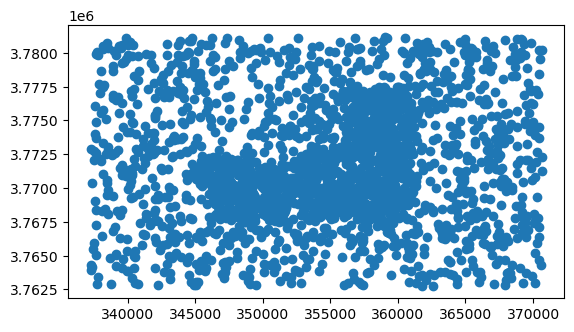

In [ ]:

sample_gdf = gpd.read_file(sample_data_path)

# Define the bounding box (minx, miny, maxx, maxy)
bbox = (minx, miny, maxx, maxy)  # Replace with actual bounds

# Create a polygon from the bounding box
bbox_polygon = box(*bbox)

# Convert the bounding box to a GeoDataFrame
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox_polygon]}, crs=sample_gdf.crs)

# Clip the original GeoDataFrame with the bounding box
clipped_gdf = gpd.overlay(sample_gdf, bbox_gdf, how='intersection')

# Count the total number of rows (data points)
total_rows = clipped_gdf.shape[0]
class_column_name='class'

# Count the number of unique classes (assuming the class column is named 'class')
unique_classes = clipped_gdf[class_column_name].nunique()

# Alternatively, to get a count of each unique class
class_counts = clipped_gdf[class_column_name].value_counts()

samples_per_class = clipped_gdf[clipped_gdf[class_column_name] == 1].shape[0]
print(samples_per_class)
# Function to sample a specified number of data points from each class
clipped_gdf = clipped_gdf.groupby('class').apply(lambda x: x.sample(n=samples_per_class, random_state=42))

# Reset index after applying the groupby operation
clipped_gdf = clipped_gdf.reset_index(drop=True)

# Display the results
print(f"Total number of rows: {total_rows}")
print(f"Number of unique classes: {unique_classes}")
print(f"Class distribution:\n{class_counts}")

# Save the clipped data to a new shapefile
clipped_gdf.to_file(clip_sample_output_path)

# Optional: Display the result
clipped_gdf.plot()

In [6]:

input_sar_image_path  = "../../Asc_SAR_Data_Processing/10_projection/subset_Asc_spksigma_TC_32611.tif"
glcm_raster_path="input/dGLCM.tif"
glcm_pca_raster_path="input/dGLCM_pca.tif"
thermal_image_path="../../ThermalData/03_diff/dTRAD.tif"
dnbr_image_path="../../S2_Data_Processing/Indices/04_CLIP/dNBR_bilinear_10_clip.tif"

In [7]:

images_dict={
            # f"{prefix}_s1_ready":input_sar_image_path,
            #  f"{prefix}_glcm_ready":glcm_raster_path,
             f"{prefix}_glcm_pca_ready":glcm_pca_raster_path,

            #  f"{prefix}_thermal_ready":thermal_image_path,
            # f"{prefix}_dnbr_ready":dnbr_image_path,
             }




### save in order: VH_PRE, VV_PRE, VH_POST, VV_POST

In [8]:

# # save in order: VH_PRE, VV_PRE, VH_POST, VV_POST
# output_ordered_image_path="input/eaton_s1_ready.tif"
# with rasterio.open(input_sar_image_path) as dataset:
#     vh_post_band=dataset.read(1)
#     vv_post_band=dataset.read(2)
#     vh_pre_band=dataset.read(3)
#     vv_pre_band=dataset.read(4)
#     meta=dataset.meta.copy()

# # Write the clipped data to a new file
# with rasterio.open(output_ordered_image_path, 'w', **meta) as dest:
#     dest.write(vh_pre_band, 1)  
#     dest.write(vv_pre_band, 2)  
#     dest.write(vh_post_band, 3)  
#     dest.write(vv_post_band, 4)  


In [9]:
for image_key in list(images_dict.keys()):
    print(image_key)

    with rasterio.open(images_dict[image_key]) as dataset:
        # Print the properties
        print(f"CRS: {dataset.crs}")
        print(f"Width: {dataset.width}")
        print(f"Height: {dataset.height}")
        print(f"Extent: {dataset.bounds}")
        print(f"Resolution: { dataset.res}")
        print("----------------------------------------")

palisades_glcm_pca_ready
CRS: EPSG:32611
Width: 8177
Height: 4569
Extent: BoundingBox(left=332846.6413521764, bottom=3757690.8796781735, right=414616.6413521764, top=3803380.8796781735)
Resolution: (10.0, 10.0)
----------------------------------------


## Clipping data by extent

In [10]:
clip_extent = (minx, miny, maxx, maxy)

In [11]:
for image_key in list(images_dict.keys()):

    # print(image_key.endswith("s1_ready"))
    # Open the raster dataset
    with rasterio.open(images_dict[image_key]) as dataset:

        # Get the window for the specified extent
        window = from_bounds(*clip_extent, dataset.transform)
        # Read the data in that window
        # clipped_data = dataset.read(1, window=window)  # Read the first band in the window
        
        # Get the new transform for the clipped data
        clipped_transform = dataset.window_transform(window)
        clipped_data = dataset.read(1, window=window)
        # Define the metadata for the clipped raster
        clipped_meta = dataset.meta.copy()
        

        if image_key.endswith("s1_ready"):
            count=4
            clipped_meta.update({
            'height': clipped_data.shape[0],
            'width': clipped_data.shape[1],
            'transform': clipped_transform,
            'count':4
        })
        else:
            count=dataset.count
            clipped_meta.update({
            'height': clipped_data.shape[0],
            'width': clipped_data.shape[1],
            'transform': clipped_transform
        })

        # bands = dataset.read()
        
        # Write the clipped data to a new file
        with rasterio.open(f'input/{image_key}.tif', 'w', **clipped_meta) as dest:
            if image_key.endswith("s1_ready"):
                vh_pre = dataset.read(3, window=window)
                vv_pre = dataset.read(4, window=window)
                vh_post= dataset.read(5, window=window)
                vv_post= dataset.read(6, window=window)
                dest.write(vh_pre, 1)
                dest.write(vv_pre, 2)
                dest.write(vh_post, 3)
                dest.write(vv_post, 4)
            else:
                for i in range(count):
                    clipped_data = dataset.read(i+1, window=window)
                    dest.write(clipped_data, i+1)  # Write the first band
